## Import Libraries

In [1]:
from Coding.Encoders import PoissonCoding
from pymonntorch import Network, NeuronGroup, Recorder, EventRecorder, SynapseGroup, NeuronDimension
from Util.Synapse import DDFSynapse
from Util.Current import ConstantCurrent
from Util.TimeResolution import TimeResolution
from Models.LIF import LIF
from matplotlib import pyplot as plt
import torch
import numpy as np
import random
from Util.Learning import SimpleSTDP
from Util.Axon import NeuronAxon
from Util.Specs import SpikeTrace, KWTA
from Util.Input import InputBehavior
import Util.Plot as pltHelper
from Util.Dendrites import LateralDendriticInput
from Util.Homeostasis import VoltageBaseHomeostasis, ActivityBaseHomeostasis

/Users/mohazamani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Set Seeds

In [2]:
seed = 2020
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## $Q1.$

### Part A

<div style="text-align: center;">
    <img title="a title" alt="Alt text" src="../ReportEN/Figs/inputq.png" style="width: 400px; height: auto;">
</div>

In this section, I aim to enhance the model by incorporating the ```Lateral Inhibition``` mechanism into the second (output) layer. The Lateral Inhibition mechanism will be added to refine the neural responses and promote the development of distinct sensitivities in neurons.

The model will be trained using two distinct patterns. By introducing these patterns, we will evaluate whether the two neurons in the second layer develop sensitivities to different aspects of the input patterns. Specifically, we will investigate if the Lateral Inhibition mechanism helps the neurons in the second layer to become more specialized and responsive to the unique features of the two patterns.


The goal of this experiment is to determine if Lateral Inhibition can enhance the neural differentiation process, leading to a clearer and more distinct pattern recognition capability in the output neurons.

In [12]:
network = Network(behavior={1: TimeResolution(dt=0.01)},
                  dtype=torch.float64, tag='NET')

neuron_model = LIF(
    tau=10,
    u_rest=-65,
    u_reset=-70,
    threshold=-40,
    R=10,
    v_init_mode="normal(-40, 10)",
)

zero_current = ConstantCurrent(value=0)

first_pattern = PoissonCoding(time_window=700, ratio=0.10)(
    torch.Tensor(plt.imread('./data/camera.tif').flatten()) / 256)
second_pattern = PoissonCoding(time_window=700, ratio=0.35)(
    torch.Tensor(plt.imread('./data/bridge.tif').flatten()) / 256)

ng1 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=first_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG1",
)

ng2 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=second_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG2",
)

ng3 = NeuronGroup(
    size=2,
    net=network,
    behavior={
        2: zero_current,
        4: neuron_model,
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        8: Recorder(variables=["v", "I"], tag="ng_rec, ng_recorder"),
        9: Recorder(variables=['iter', 'spike_counts'], tag='iter_rec, spike_n_rec'),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG3",
)

s1 = SynapseGroup(net=network, src=ng1, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights1")
}, tag='excitatory, ex1')

s2 = SynapseGroup(net=network, src=ng2, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights2")
}, tag='excitatory, ex2')

s3 = SynapseGroup(net=network, src=ng3, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=2),
    # 4: LateralDendriticInput(inhibitory=1, current_coef=1000),
    10: Recorder("W", tag="weights5")
}, tag='inhibitory')


network.initialize()
network.simulate_iterations(700)

Network['NET', 'Network'](Neurons: tensor(10)|3 groups, Synapses: tensor(20)|3 groups){1:TimeResolution(dt=0.01,)}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=1,)6:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=True,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_evrec,arg_0=spike,)}
NeuronGroup['NG2', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=1,)6:NeuronAxon(max_delay=1,

336.1937999725342

In [13]:
data = []

for i in range(700):
    data.append(
        torch.cat((first_pattern[20000:20004, i], second_pattern[20000:20004, i]), 0))

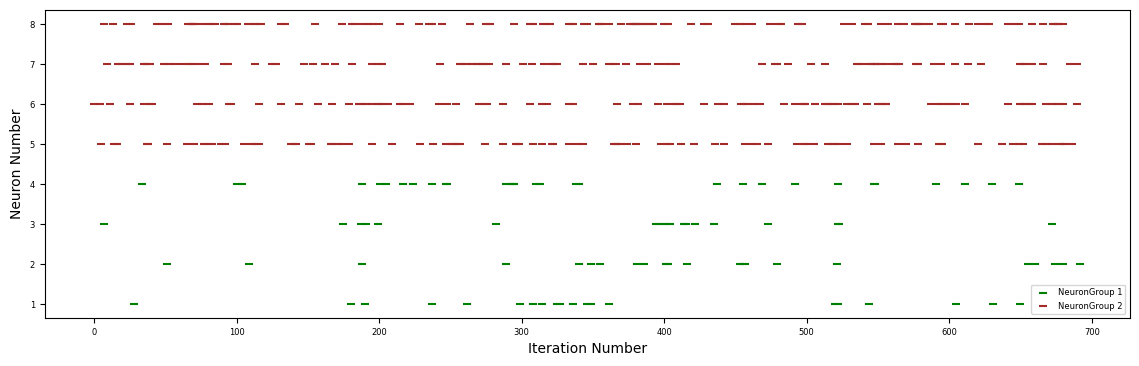

In [22]:
# Convert to numpy array
data_np = np.array([t.numpy() for t in data])

# Initialize lists to hold the positions for the scatter plot
x1, x2 = [], []
y1, y2 = [], []

# Extract positions where elements are one
for i, tensor in enumerate(data_np):
    for j, value in enumerate(tensor):
        if value == 1 and j < 4:
            y1.append(j + 1)
            x1.append(i)
        elif value == 1:
            y2.append(j + 1)
            x2.append(i)


# Create the scatter plot
plt.figure(figsize=(14, 4))
plt.scatter(x1, y1, marker='_', color='green', label="NeuronGroup 1")
plt.scatter(x2, y2, marker='_', color='brown', label="NeuronGroup 2")
plt.xlabel('Iteration Number', fontsize=10)
plt.ylabel('Neuron Number', fontsize=10)
plt.legend()
plt.show()

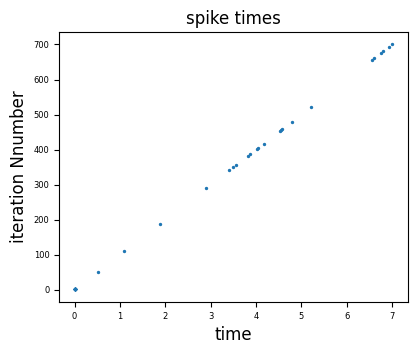

In [15]:
pltHelper.spike_times_plot(ng1, 2)

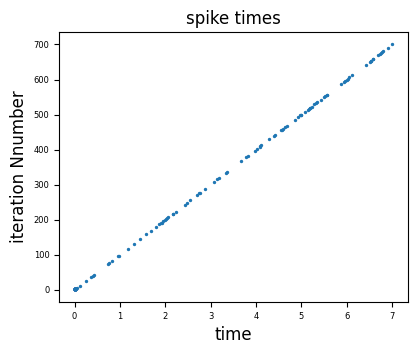

In [16]:
pltHelper.spike_times_plot(ng2, 2)

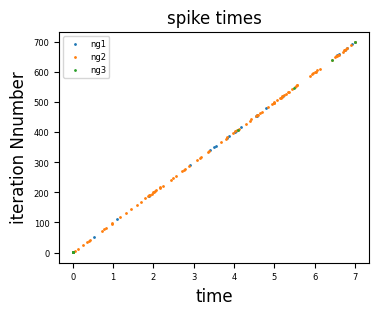

In [17]:
pltHelper.spike_times_for_multiple_ng([ng1, ng2, ng3])

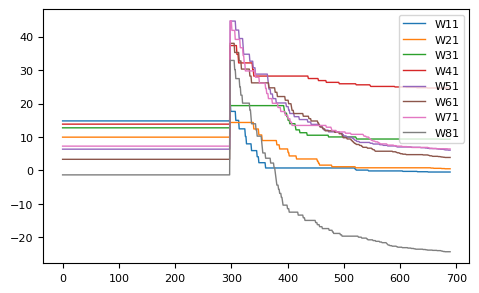

In [18]:
pltHelper.plot_weights_changes_of_specific_output__in_stdp(s1, s2, 0)

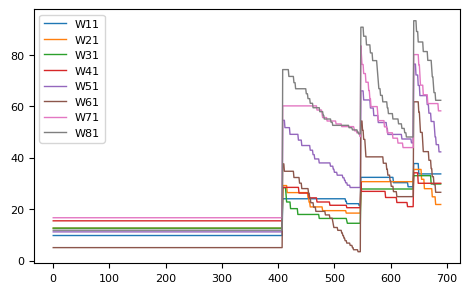

In [19]:
pltHelper.plot_weights_changes_of_specific_output__in_stdp(s1, s2, 1)

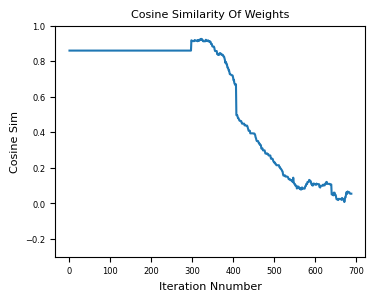

In [20]:
pltHelper.cosine_similarity_plot(s1, s2, [-0.3, 1])

### Part B

In this section, we will replicate the experiment from the previous question, but this time we will introduce different levels of ```overlap``` between the two patterns used for training. By systematically varying the amount of shared features between the patterns, we aim to explore how pattern similarity affects the sensitivity and specialization of the neurons in the second (output) layer.



#### B.1 : One overlap

In [3]:
first_pattern = PoissonCoding(time_window=700, ratio=0.10)(
    torch.Tensor(plt.imread('./data/camera.tif').flatten()) / 256)
second_pattern = PoissonCoding(time_window=700, ratio=0.35)(
    torch.Tensor(plt.imread('./data/bridge.tif').flatten()) / 256)

second_pattern[20000] = first_pattern[20000]
second_pattern[20001] = first_pattern[20001]

In [17]:
network = Network(behavior={1: TimeResolution(dt=0.01)},
                  dtype=torch.float64, tag='NET')

neuron_model = LIF(
    tau=10,
    u_rest=-65,
    u_reset=-70,
    threshold=-40,
    R=10,
    v_init_mode="normal(-40, 10)",
)

zero_current = ConstantCurrent(value=0)

ng1 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=first_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG1",
)

ng2 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=second_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG2",
)

ng3 = NeuronGroup(
    size=2,
    net=network,
    behavior={
        2: zero_current,
        4: neuron_model,
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        8: Recorder(variables=["v", "I"], tag="ng_rec, ng_recorder"),
        9: Recorder(variables=['iter', 'spike_counts'], tag='iter_rec, spike_n_rec'),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG3",
)

s1 = SynapseGroup(net=network, src=ng1, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights1")
}, tag='excitatory, ex1')

s2 = SynapseGroup(net=network, src=ng2, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights2")
}, tag='excitatory, ex2')

s3 = SynapseGroup(net=network, src=ng3, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=2),
    # 4: LateralDendriticInput(inhibitory=1, current_coef=1000),
    10: Recorder("W", tag="weights5")
}, tag='inhibitory')


network.initialize()
network.simulate_iterations(700)

Network['NET', 'Network'](Neurons: tensor(10)|3 groups, Synapses: tensor(20)|3 groups){1:TimeResolution(dt=0.01,)}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=1,)6:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=True,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_evrec,arg_0=spike,)}
NeuronGroup['NG2', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=1,)6:NeuronAxon(max_delay=1,

343.5556888580322

In [28]:
data = []

for i in range(700):
    data.append(
        torch.cat((first_pattern[20000:20004, i], second_pattern[20000:20004, i]), 0))

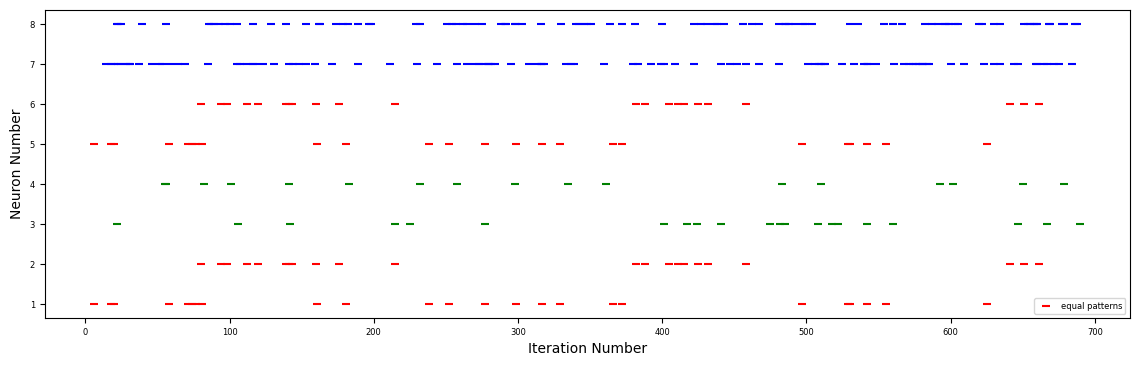

In [32]:
# Convert to numpy array
data_np = np.array([t.numpy() for t in data])

# Initialize lists to hold the positions for the scatter plot
x1, x2, x3, x4 = [], [], [], []
y1, y2, y3, y4 = [], [], [], []

# Extract positions where elements are one
for i, tensor in enumerate(data_np):
    for j, value in enumerate(tensor):
        if value == 1 and (j == 0 or j == 1):
            y1.append(j + 1)
            x1.append(i)
        elif value == 1 and (j == 2 or j == 3):
            y2.append(j + 1)
            x2.append(i)
        elif value == 1 and (j == 4 or j == 5):
            y3.append(j + 1)
            x3.append(i)
        elif value == 1:
            y4.append(j + 1)
            x4.append(i)


# Create the scatter plot
plt.figure(figsize=(14, 4))
plt.scatter(x1, y1, marker='_', color='red', label="equal patterns")
plt.scatter(x2, y2, marker='_', color='green')
plt.scatter(x3, y3, marker='_', color='red')
plt.scatter(x4, y4, marker='_', color='blue')
plt.xlabel('Iteration Number', fontsize=10)
plt.ylabel('Neuron Number', fontsize=10)
plt.legend()
plt.show()

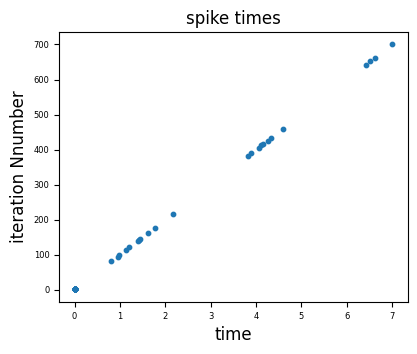

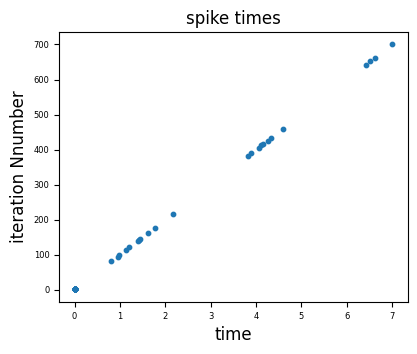

In [20]:
pltHelper.spike_times_plot(ng1)
pltHelper.spike_times_plot(ng2)

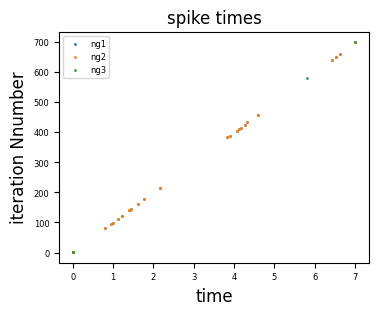

In [21]:
pltHelper.spike_times_for_multiple_ng([ng1, ng2, ng3])

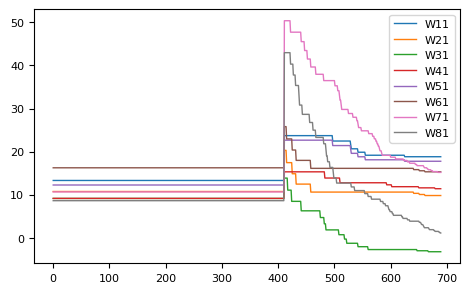

In [23]:
pltHelper.plot_weights_changes_of_specific_output__in_stdp(s1, s2, 0)

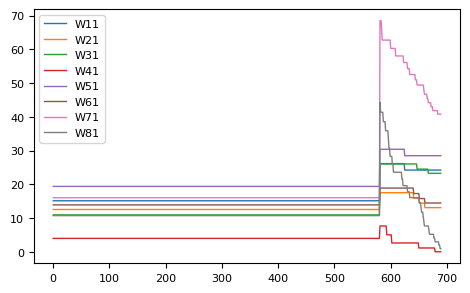

In [24]:
pltHelper.plot_weights_changes_of_specific_output__in_stdp(s1, s2, 1)

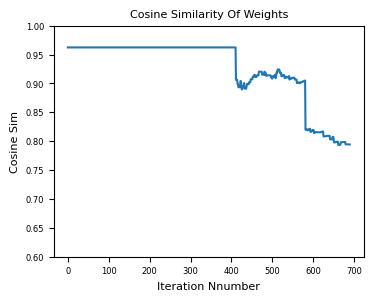

In [26]:
pltHelper.cosine_similarity_plot(s1, s2, [0.6, 1])

#### B.2: Two Overlap

In [3]:
pattern_one = PoissonCoding(time_window=700, ratio=0.15)(
    torch.Tensor(plt.imread('./data/bird.tif').flatten()) / 256)

pattern_two = PoissonCoding(time_window=700, ratio=0.4)(
    torch.Tensor(plt.imread('./data/bridge.tif').flatten()) / 256)

pattern_two[:2] = pattern_one[:2]

In [4]:
network = Network(behavior={1: TimeResolution(dt=0.01)},
                  dtype=torch.float64, tag='NET')

neuron_model = LIF(
    tau=10,
    u_rest=-65,
    u_reset=-70,
    threshold=-40,
    R=10,
    v_init_mode="normal(-40, 10)",
)

zero_current = ConstantCurrent(value=0)

ng1 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=pattern_one),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG1",
)

ng2 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=pattern_two),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG2",
)

ng3 = NeuronGroup(
    size=2,
    net=network,
    behavior={
        2: zero_current,
        4: neuron_model,
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(),
        8: Recorder(variables=["v", "I"], tag="ng_rec, ng_recorder"),
        9: Recorder(variables=['iter', 'spike_counts'], tag='iter_rec, spike_n_rec'),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG3",
)

s1 = SynapseGroup(net=network, src=ng1, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=50, std=5),
    6: SimpleSTDP(a_plus=2, a_minus=2, positive_bound='hard_bound', negative_bound='hard_bound', w_max=130, w_min=-1000),
    4: Recorder("W", tag="weights")
}, tag='excitatory')

s2 = SynapseGroup(net=network, src=ng2, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=50, std=5),
    6: SimpleSTDP(a_plus=2, a_minus=2, positive_bound='hard_bound', negative_bound='hard_bound', w_max=130, w_min=-1000),
    4: Recorder("W", tag="weights")
}, tag='excitatory')

s3 = SynapseGroup(net=network, src=ng3, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=0, std=0),
    4: LateralDendriticInput(current_coef=1000),
    4: Recorder("W", tag="weights")
}, tag='excitatory3')

network.initialize()
network.simulate_iterations(700)

Network['NET', 'Network'](Neurons: tensor(10)|3 groups, Synapses: tensor(20)|3 groups){1:TimeResolution(dt=0.01,)}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=1,)6:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_evrec,arg_0=spike,)}
NeuronGroup['NG2', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [1, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=1,)6:NeuronAxon(max_delay=1,

764.8029327392578

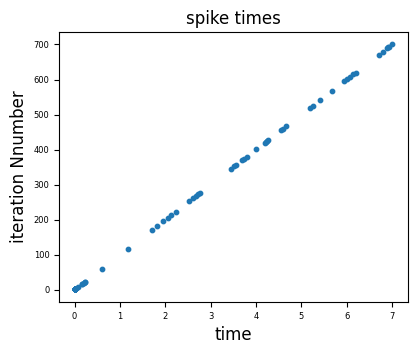

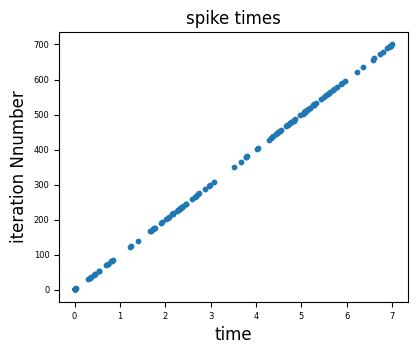

In [5]:
pltHelper.spike_times_plot(ng1)
pltHelper.spike_times_plot(ng2)

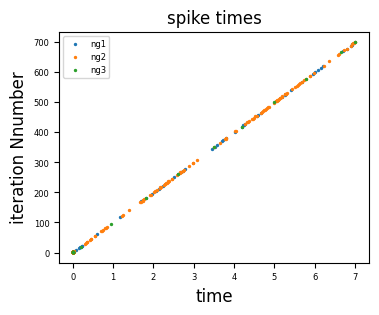

In [6]:
pltHelper.spike_times_for_multiple_ng([ng1, ng2, ng3])

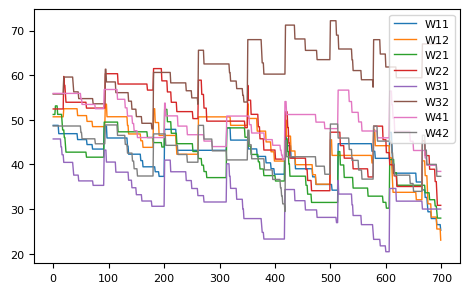

In [7]:
pltHelper.plot_weights_changes_in_stdp(s1)

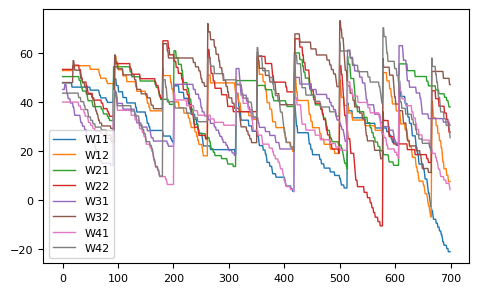

In [8]:
pltHelper.plot_weights_changes_in_stdp(s2)

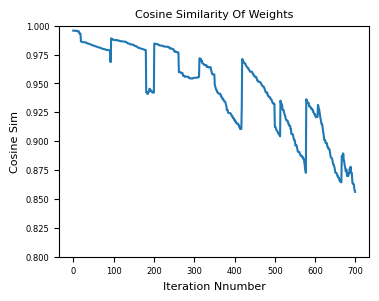

In [9]:
pltHelper.cosine_similarity_plot(s1, s2, [0.8, 1])

#### B.3: Three Overlap

In [3]:
pattern_one = PoissonCoding(time_window=700, ratio=0.3)(
    torch.Tensor(plt.imread('./data/bird.tif').flatten()) / 256)

pattern_two = PoissonCoding(time_window=700, ratio=0.3)(
    torch.Tensor(plt.imread('./data/bridge.tif').flatten()) / 256)

pattern_two[:3] = pattern_one[:3]

In [4]:
network = Network(behavior={1: TimeResolution(dt=0.01)},
                  dtype=torch.float64, tag='NET')

neuron_model = LIF(
    tau=10,
    u_rest=-65,
    u_reset=-70,
    threshold=-40,
    R=10,
    v_init_mode="normal(-40, 10)",
)

zero_current = ConstantCurrent(value=0)

ng1 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=pattern_one),
        5: SpikeTrace(tau_s=10),
        6: NeuronAxon(),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG1",
)

ng2 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=pattern_one),
        5: SpikeTrace(tau_s=10),
        6: NeuronAxon(),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG2",
)

ng3 = NeuronGroup(
    size=2,
    net=network,
    behavior={
        2: zero_current,
        4: neuron_model,
        5: SpikeTrace(tau_s=10),
        6: NeuronAxon(),
        8: Recorder(variables=["v", "I"], tag="ng_rec, ng_recorder"),
        9: Recorder(variables=['iter', 'spike_counts'], tag='iter_rec, spike_n_rec'),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG3",
)


s1 = SynapseGroup(net=network, src=ng1, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=50, std=5),
    6: SimpleSTDP(a_plus=2, a_minus=2, positive_bound='hard_bound', negative_bound='hard_bound', w_max=130, w_min=-1000),
    4: Recorder("W", tag="weights")
}, tag='excitatory')

s2 = SynapseGroup(net=network, src=ng2, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=50, std=5),
    6: SimpleSTDP(a_plus=2, a_minus=2, positive_bound='hard_bound', negative_bound='hard_bound', w_max=130, w_min=-1000),
    4: Recorder("W", tag="weights")
}, tag='excitatory')

s3 = SynapseGroup(net=network, src=ng3, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=0, std=0),
    4: LateralDendriticInput(inhibitory=100),
    4: Recorder("W", tag="weights")
}, tag='excitatory3')

network.initialize()
network.simulate_iterations(700)

Network['NET', 'Network'](Neurons: tensor(10)|3 groups, Synapses: tensor(20)|3 groups){1:TimeResolution(dt=0.01,)}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 1, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=10,)6:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_evrec,arg_0=spike,)}
NeuronGroup['NG2', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 1, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=10,)6:NeuronAxon(max_delay=

339.94102478027344

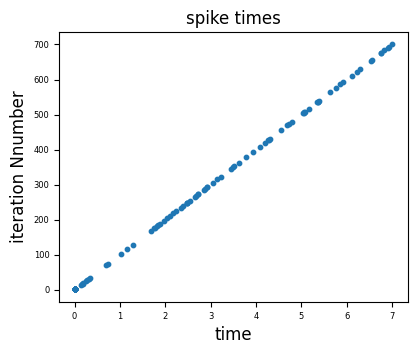

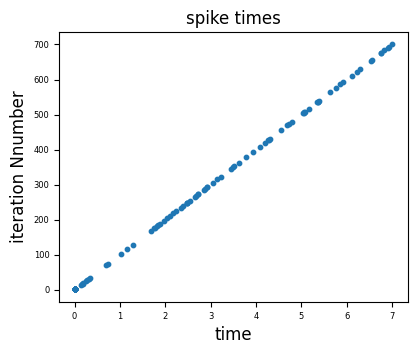

In [5]:
pltHelper.spike_times_plot(ng1)
pltHelper.spike_times_plot(ng2)

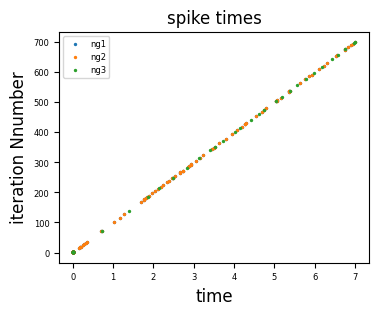

In [6]:
pltHelper.spike_times_for_multiple_ng([ng1, ng2, ng3])

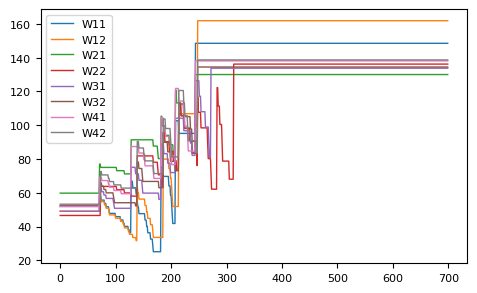

In [7]:
pltHelper.plot_weights_changes_in_stdp(s1)

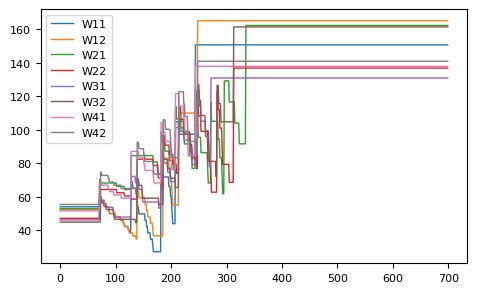

In [8]:
pltHelper.plot_weights_changes_in_stdp(s2)

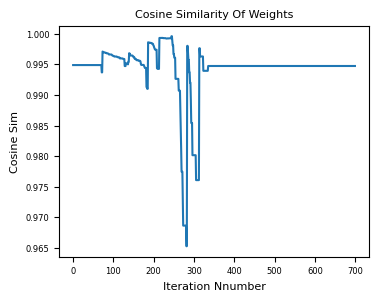

In [9]:
pltHelper.cosine_similarity_plot(s1, s2)

#### B.4 Four Overlap, Same

In [3]:
first_pattern = PoissonCoding(time_window=700, ratio=0.10)(
    torch.Tensor(plt.imread('./data/camera.tif').flatten()) / 256)
second_pattern = PoissonCoding(time_window=700, ratio=0.35)(
    torch.Tensor(plt.imread('./data/bridge.tif').flatten()) / 256)

first_pattern = second_pattern

In [13]:
network = Network(behavior={1: TimeResolution(dt=0.01)},
                  dtype=torch.float64, tag='NET')

neuron_model = LIF(
    tau=10,
    u_rest=-65,
    u_reset=-70,
    threshold=-40,
    R=10,
    v_init_mode="normal(-40, 10)",
)

zero_current = ConstantCurrent(value=0)

ng1 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=first_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG1",
)

ng2 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=second_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG2",
)

ng3 = NeuronGroup(
    size=2,
    net=network,
    behavior={
        2: zero_current,
        4: neuron_model,
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        8: Recorder(variables=["v", "I"], tag="ng_rec, ng_recorder"),
        9: Recorder(variables=['iter', 'spike_counts'], tag='iter_rec, spike_n_rec'),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG3",
)

s1 = SynapseGroup(net=network, src=ng1, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights1")
}, tag='excitatory, ex1')

s2 = SynapseGroup(net=network, src=ng2, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights2")
}, tag='excitatory, ex2')

s3 = SynapseGroup(net=network, src=ng3, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=2),
    # 4: LateralDendriticInput(inhibitory=1, current_coef=1000),
    10: Recorder("W", tag="weights5")
}, tag='inhibitory')


network.initialize()
network.simulate_iterations(700)

Network['NET', 'Network'](Neurons: tensor(10)|3 groups, Synapses: tensor(20)|3 groups){1:TimeResolution(dt=0.01,)}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=1,)6:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=True,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_evrec,arg_0=spike,)}
NeuronGroup['NG2', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=1,)6:NeuronAxon(max_delay=1,

345.9651470184326

In [14]:
data = []

for i in range(700):
    data.append(
        torch.cat((first_pattern[20000:20004, i], second_pattern[20000:20004, i]), 0))

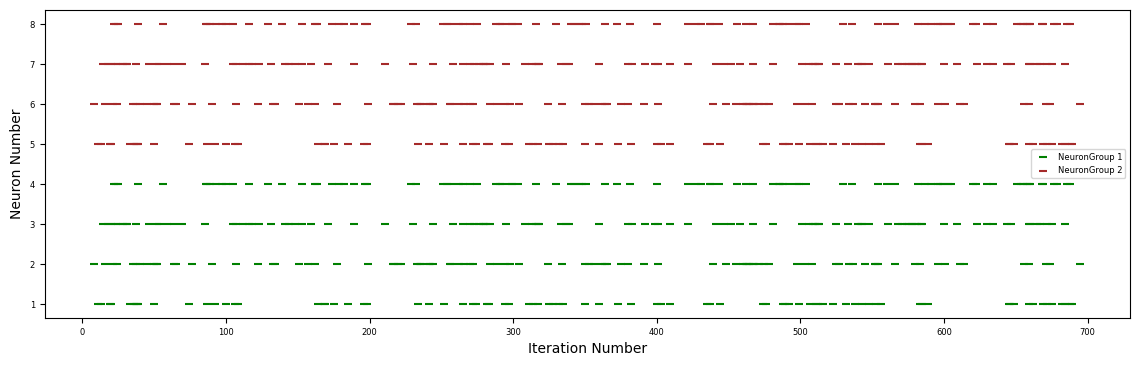

In [15]:
# Convert to numpy array
data_np = np.array([t.numpy() for t in data])

# Initialize lists to hold the positions for the scatter plot
x1, x2 = [], []
y1, y2 = [], []

# Extract positions where elements are one
for i, tensor in enumerate(data_np):
    for j, value in enumerate(tensor):
        if value == 1 and j < 4:
            y1.append(j + 1)
            x1.append(i)
        elif value == 1:
            y2.append(j + 1)
            x2.append(i)


# Create the scatter plot
plt.figure(figsize=(14, 4))
plt.scatter(x1, y1, marker='_', color='green', label="NeuronGroup 1")
plt.scatter(x2, y2, marker='_', color='brown', label="NeuronGroup 2")
plt.xlabel('Iteration Number', fontsize=10)
plt.ylabel('Neuron Number', fontsize=10)
plt.legend()
plt.show()

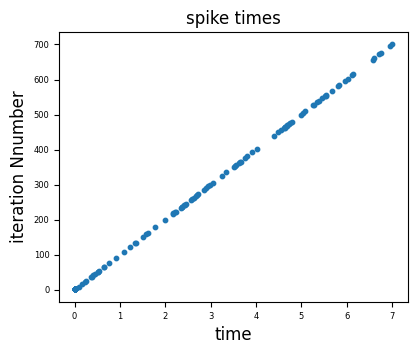

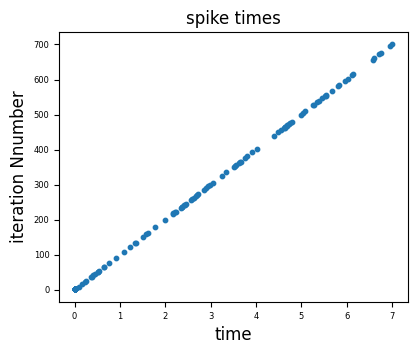

In [16]:
pltHelper.spike_times_plot(ng1)
pltHelper.spike_times_plot(ng2)

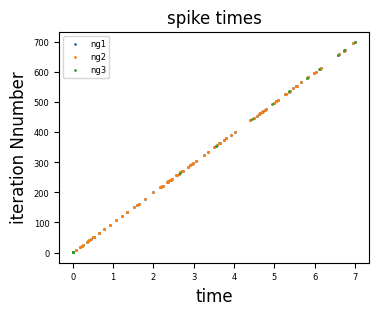

In [17]:
pltHelper.spike_times_for_multiple_ng([ng1, ng2, ng3])

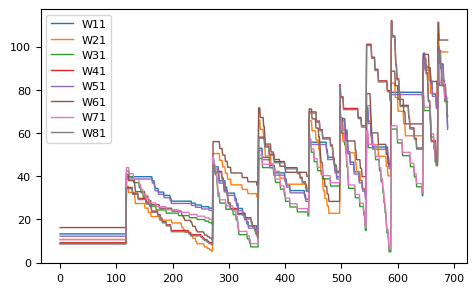

In [18]:
pltHelper.plot_weights_changes_of_specific_output__in_stdp(s1, s2, 0)

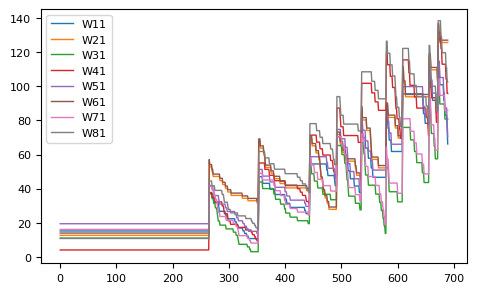

In [19]:
pltHelper.plot_weights_changes_of_specific_output__in_stdp(s1, s2, 1)

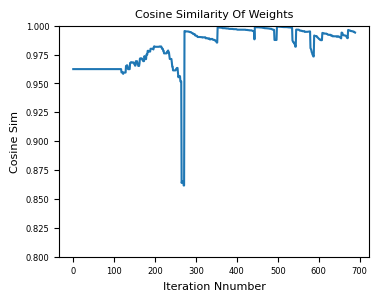

In [23]:
pltHelper.cosine_similarity_plot(s1, s2, [0.8, 1])

### Part C

I would like to incorporate the ```k-Winners-Take-All``` mechanism into my model specifically within the output layer in this section. This approach will enhance the model's performance by ensuring that only the top k activations are retained, thereby promoting sparsity and improving the overall effectiveness of the output representation.

#### C.1 : Different Pattern

In [11]:
network = Network(behavior={1: TimeResolution(dt=0.01)},
                  dtype=torch.float64, tag='NET')

neuron_model = LIF(
    tau=10,
    u_rest=-65,
    u_reset=-70,
    threshold=-40,
    R=10,
    v_init_mode="normal(-40, 10)",
)

zero_current = ConstantCurrent(value=0)

first_pattern = PoissonCoding(time_window=700, ratio=0.10)(
    torch.Tensor(plt.imread('./data/camera.tif').flatten()) / 256)
second_pattern = PoissonCoding(time_window=700, ratio=0.35)(
    torch.Tensor(plt.imread('./data/bridge.tif').flatten()) / 256)

ng1 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=first_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG1",
)

ng2 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=second_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG2",
)

ng3 = NeuronGroup(
    size=2,
    net=network,
    behavior={
        2: zero_current,
        4: neuron_model,
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        7: KWTA(k=1, dimension=1),
        8: Recorder(variables=["v", "I"], tag="ng_rec, ng_recorder"),
        9: Recorder(variables=['iter', 'spike_counts'], tag='iter_rec, spike_n_rec'),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG3",
)

s1 = SynapseGroup(net=network, src=ng1, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights1")
}, tag='excitatory, ex1')

s2 = SynapseGroup(net=network, src=ng2, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights2")
}, tag='excitatory, ex2')

s3 = SynapseGroup(net=network, src=ng3, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=2),
    # 4: LateralDendriticInput(inhibitory=1, current_coef=1000),

    10: Recorder("W", tag="weights5")
}, tag='inhibitory')


network.initialize()
network.simulate_iterations(700)

Network['NET', 'Network'](Neurons: tensor(10)|3 groups, Synapses: tensor(20)|3 groups){1:TimeResolution(dt=0.01,)}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=1,)6:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=True,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_evrec,arg_0=spike,)}
NeuronGroup['NG2', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=1,)6:NeuronAxon(max_delay=1,

350.0039577484131

In [12]:
data = []

for i in range(700):
    data.append(
        torch.cat((first_pattern[20000:20004, i], second_pattern[20000:20004, i]), 0))

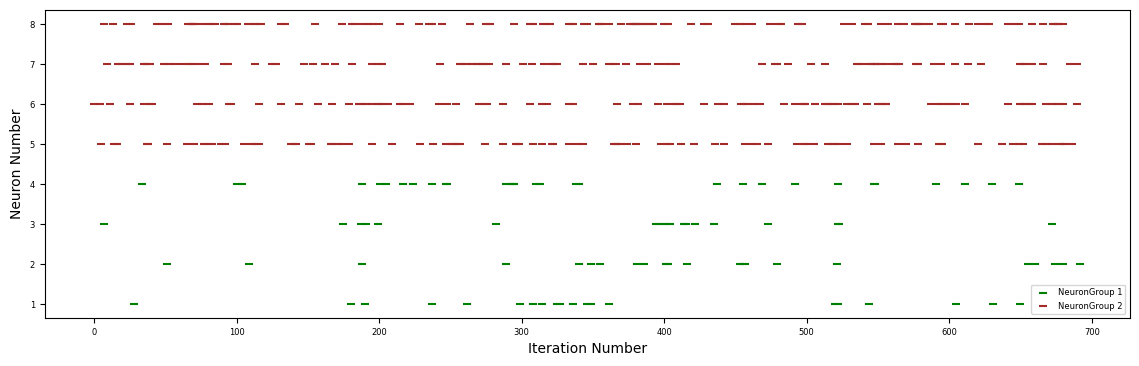

In [13]:
# Convert to numpy array
data_np = np.array([t.numpy() for t in data])

# Initialize lists to hold the positions for the scatter plot
x1, x2 = [], []
y1, y2 = [], []

# Extract positions where elements are one
for i, tensor in enumerate(data_np):
    for j, value in enumerate(tensor):
        if value == 1 and j < 4:
            y1.append(j + 1)
            x1.append(i)
        elif value == 1:
            y2.append(j + 1)
            x2.append(i)


# Create the scatter plot
plt.figure(figsize=(14, 4))
plt.scatter(x1, y1, marker='_', color='green', label="NeuronGroup 1")
plt.scatter(x2, y2, marker='_', color='brown', label="NeuronGroup 2")
plt.xlabel('Iteration Number', fontsize=10)
plt.ylabel('Neuron Number', fontsize=10)
plt.legend()
plt.show()

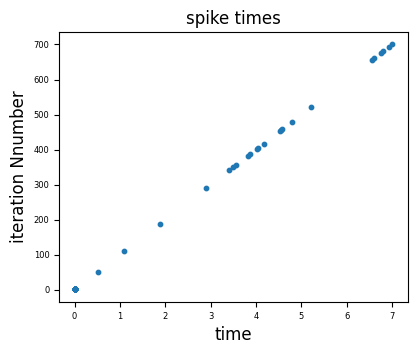

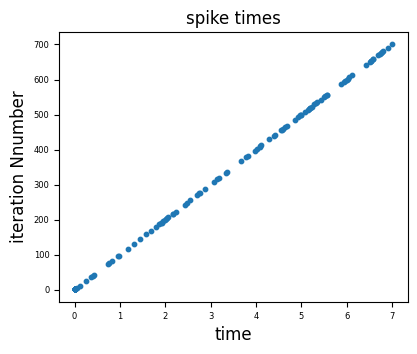

In [14]:
pltHelper.spike_times_plot(ng1)
pltHelper.spike_times_plot(ng2)

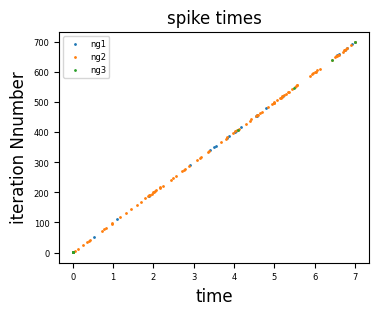

In [15]:
pltHelper.spike_times_for_multiple_ng([ng1, ng2, ng3])

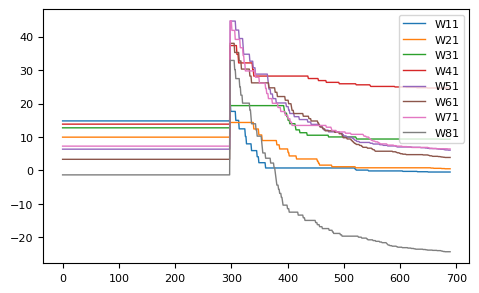

In [16]:
pltHelper.plot_weights_changes_of_specific_output__in_stdp(s1, s2, 0)

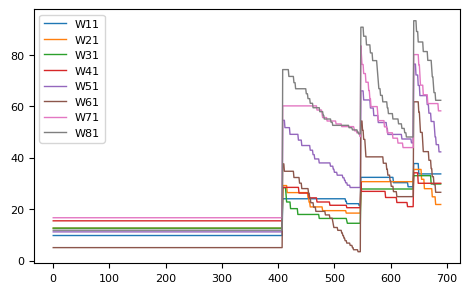

In [17]:
pltHelper.plot_weights_changes_of_specific_output__in_stdp(s1, s2, 1)

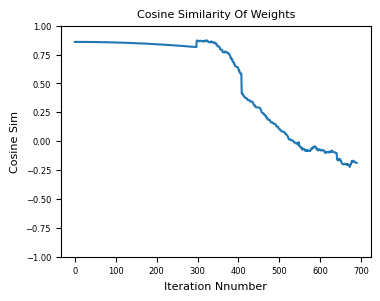

In [18]:
pltHelper.cosine_similarity_plot(s1, s2, [-1, 1])

#### C.2 : Two overlap

In [3]:
first_pattern = PoissonCoding(time_window=700, ratio=0.10)(
    torch.Tensor(plt.imread('./data/camera.tif').flatten()) / 256)
second_pattern = PoissonCoding(time_window=700, ratio=0.35)(
    torch.Tensor(plt.imread('./data/bridge.tif').flatten()) / 256)

second_pattern[20000] = first_pattern[20000]
second_pattern[20001] = first_pattern[20001]

In [12]:
network = Network(behavior={1: TimeResolution(dt=0.01)},
                  dtype=torch.float64, tag='NET')

neuron_model = LIF(
    tau=10,
    u_rest=-65,
    u_reset=-70,
    threshold=-40,
    R=10,
    v_init_mode="normal(-40, 10)",
)

zero_current = ConstantCurrent(value=0)

ng1 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=first_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG1",
)

ng2 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=second_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG2",
)

ng3 = NeuronGroup(
    size=2,
    net=network,
    behavior={
        2: zero_current,
        4: neuron_model,
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        7: KWTA(k=1, dimension=1),
        8: Recorder(variables=["v", "I"], tag="ng_rec, ng_recorder"),
        9: Recorder(variables=['iter', 'spike_counts'], tag='iter_rec, spike_n_rec'),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG3",
)

s1 = SynapseGroup(net=network, src=ng1, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights1")
}, tag='excitatory, ex1')

s2 = SynapseGroup(net=network, src=ng2, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights2")
}, tag='excitatory, ex2')

s3 = SynapseGroup(net=network, src=ng3, dst=ng3, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=2),
    # 4: LateralDendriticInput(inhibitory=1, current_coef=1000),
    10: Recorder("W", tag="weights5")
}, tag='inhibitory')


network.initialize()
network.simulate_iterations(700)

Network['NET', 'Network'](Neurons: tensor(10)|3 groups, Synapses: tensor(20)|3 groups){1:TimeResolution(dt=0.01,)}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=1,)6:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=True,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_evrec,arg_0=spike,)}
NeuronGroup['NG2', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=1,)6:NeuronAxon(max_delay=1,

395.30205726623535

In [13]:
data = []

for i in range(700):
    data.append(
        torch.cat((first_pattern[20000:20004, i], second_pattern[20000:20004, i]), 0))

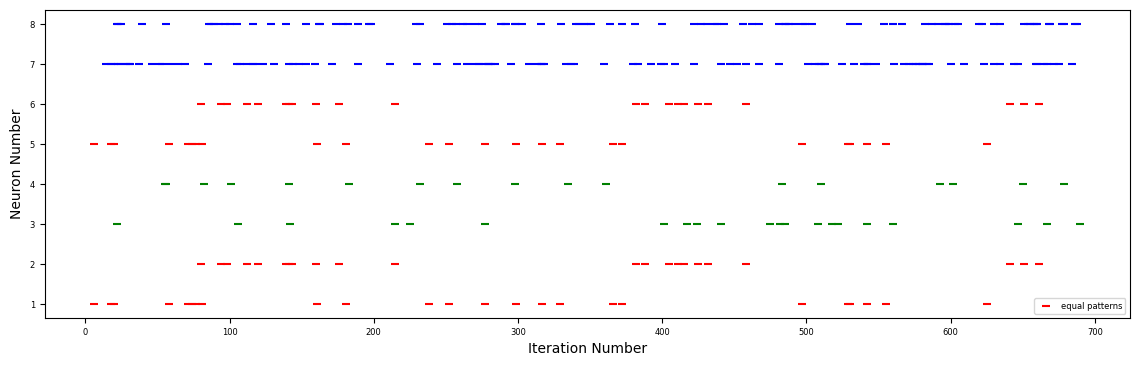

In [14]:
# Convert to numpy array
data_np = np.array([t.numpy() for t in data])

# Initialize lists to hold the positions for the scatter plot
x1, x2, x3, x4 = [], [], [], []
y1, y2, y3, y4 = [], [], [], []

# Extract positions where elements are one
for i, tensor in enumerate(data_np):
    for j, value in enumerate(tensor):
        if value == 1 and (j == 0 or j == 1):
            y1.append(j + 1)
            x1.append(i)
        elif value == 1 and (j == 2 or j == 3):
            y2.append(j + 1)
            x2.append(i)
        elif value == 1 and (j == 4 or j == 5):
            y3.append(j + 1)
            x3.append(i)
        elif value == 1:
            y4.append(j + 1)
            x4.append(i)


# Create the scatter plot
plt.figure(figsize=(14, 4))
plt.scatter(x1, y1, marker='_', color='red', label="equal patterns")
plt.scatter(x2, y2, marker='_', color='green')
plt.scatter(x3, y3, marker='_', color='red')
plt.scatter(x4, y4, marker='_', color='blue')
plt.xlabel('Iteration Number', fontsize=10)
plt.ylabel('Neuron Number', fontsize=10)
plt.legend()
plt.show()

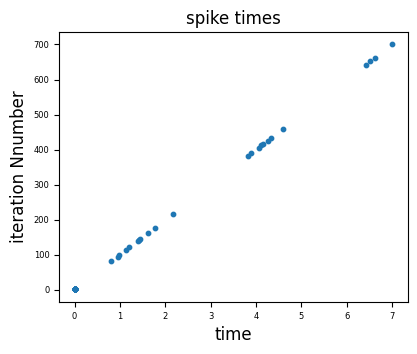

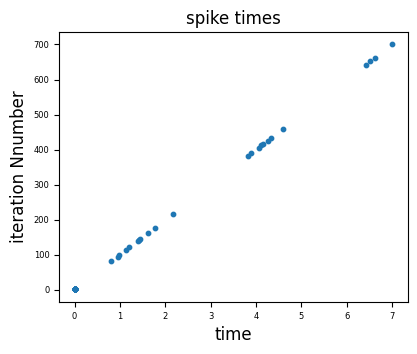

In [15]:
pltHelper.spike_times_plot(ng1)
pltHelper.spike_times_plot(ng2)

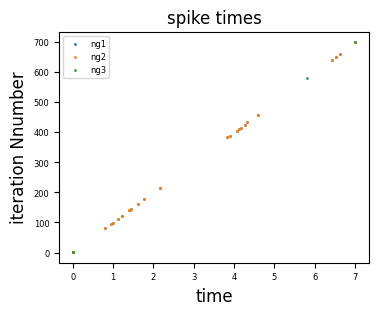

In [16]:
pltHelper.spike_times_for_multiple_ng([ng1, ng2, ng3])

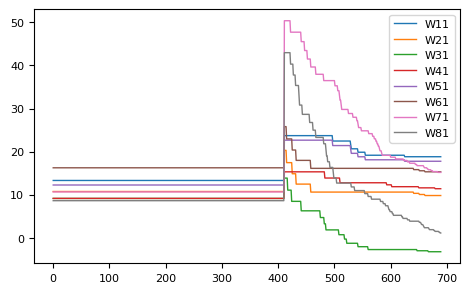

In [17]:
pltHelper.plot_weights_changes_of_specific_output__in_stdp(s1, s2, 0)

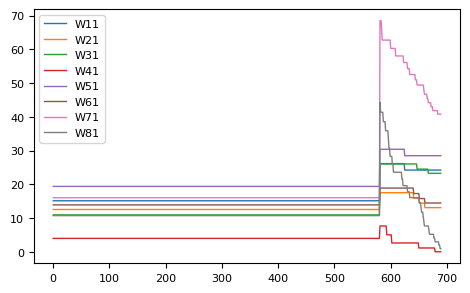

In [18]:
pltHelper.plot_weights_changes_of_specific_output__in_stdp(s1, s2, 1)

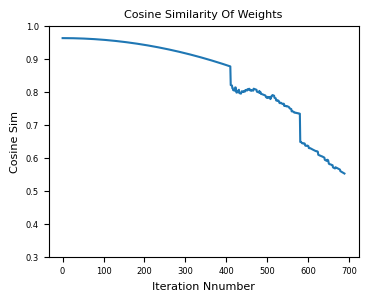

In [23]:
pltHelper.cosine_similarity_plot(s1, s2, [0.3, 1])

## $Q2.$

<div style="text-align: center;">
    <img title="a title" alt="Alt text" src="../ReportEN/Figs/h.jpg" style="width: 400px; height: auto;">
    <p style="font-size: 14px; color: gray;">Homeostasis: positive/ negative feedback mechanisms example</p>
</div>


```Homeostasis``` refers to the stability, balance, or equilibrium of the body's internal environment. It involves the body's continuous efforts to maintain a constant and balanced state through persistent monitoring and adjustments in response to changing conditions. This process, known as homeostatic regulation, comprises three key components: the receptor, the control center, and the effector.


> 1. The Receptor: Detects changes in the environment.

> 2. The Control Center: Receives and processes information from the receptor.

>  3. The Effector: Responds to the control center's commands by either opposing or enhancing the stimulus.


These components work together to restore and maintain homeostasis. For example, in regulating body temperature, temperature receptors in the skin send information to the brain (the control center), which then signals effectors such as blood vessels and sweat glands in the skin. Due to the constant changes in both the internal and external environment, the body must continuously make adjustments to stay at or near a specific value, known as the set point.

In [3]:
first_pattern = PoissonCoding(time_window=700, ratio=0.10)(
    torch.Tensor(plt.imread('./data/camera.tif').flatten()) / 256)
second_pattern = PoissonCoding(time_window=700, ratio=0.25)(
    torch.Tensor(plt.imread('./data/bridge.tif').flatten()) / 256)
third_pattern = PoissonCoding(time_window=700, ratio=0.07)(
    torch.Tensor(plt.imread('./data/bird.tif').flatten()) / 256)
fourth_pattern = PoissonCoding(time_window=700, ratio=0.05)(
    torch.Tensor(plt.imread('./data/lena1.tif').flatten()) / 256)
fiveth_pattern = fourth_pattern = PoissonCoding(time_window=700, ratio=0.35)(
    torch.Tensor(plt.imread('./data/goldhill.tif').flatten()) / 256)

In [4]:
network = Network(behavior={1: TimeResolution(dt=0.01)},
                  dtype=torch.float64, tag='NET')

neuron_model = LIF(
    tau=10,
    u_rest=-65,
    u_reset=-70,
    threshold=-40,
    R=10,
    v_init_mode="normal(-40, 10)",
)

zero_current = ConstantCurrent(value=0)

ng1 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=first_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG1",
)

ng2 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=second_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG2",
)

ng3 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=third_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG3",
)

ng4 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=fourth_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG4",
)

ng5 = NeuronGroup(
    size=4,
    net=network,
    behavior={
        2: InputBehavior(spikes=fiveth_pattern),
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        10: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG5",
)

ng6 = NeuronGroup(
    size=5,
    net=network,
    behavior={
        2: zero_current,
        4: neuron_model,
        5: SpikeTrace(tau_s=1),
        6: NeuronAxon(have_trace=True),
        7: KWTA(k=1, dimension=1),
        8: ActivityBaseHomeostasis(activity_rate=0.1, window_size=1, updating_rate=0.1),
        9: Recorder(variables=["v", "I"], tag="ng_rec, ng_recorder"),
        10: Recorder(variables=['iter', 'spike_counts'], tag='iter_rec, spike_n_rec'),
        11: EventRecorder("spike", tag="ng_evrec"),
    },
    tag="NG6",
)

s1 = SynapseGroup(net=network, src=ng1, dst=ng6, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights1")
}, tag='excitatory, ex1')

s2 = SynapseGroup(net=network, src=ng2, dst=ng6, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights2")
}, tag='excitatory, ex2')


s3 = SynapseGroup(net=network, src=ng3, dst=ng6, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights3")
}, tag='excitatory, ex3')


s4 = SynapseGroup(net=network, src=ng4, dst=ng6, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights4")
}, tag='excitatory, ex4')

s5 = SynapseGroup(net=network, src=ng5, dst=ng6, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=5),
    7: SimpleSTDP(a_plus=3, a_minus=3, positive_bound='hard_bound', negative_bound='hard_bound', w_max=200, w_min=-200),
    10: Recorder("W", tag="weights5")
}, tag='excitatory, ex5')

s6 = SynapseGroup(net=network, src=ng6, dst=ng6, behavior={
    3: DDFSynapse(connection_mode='full', mean=10, std=2),
    # 4: LateralDendriticInput(inhibitory=1, current_coef=1000),
    10: Recorder("W", tag="weights6")
}, tag='inhibitory')


network.initialize()
network.simulate_iterations(700)

Network['NET', 'Network'](Neurons: tensor(25)|6 groups, Synapses: tensor(125)|6 groups){1:TimeResolution(dt=0.01,)}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=1,)6:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=True,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng_evrec,arg_0=spike,)}
NeuronGroup['NG2', 'NeuronGroup', 'ng'](4){2:InputBehavior(spikes=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),)5:SpikeTrace(tau_s=1,)6:NeuronAxon(max_delay=1

648.9920616149902

In [5]:
data = []

for i in range(700):
    data.append(
        torch.cat((first_pattern[20000:20004, i], second_pattern[20000:20004, i],
                   third_pattern[20000:20004, i], fourth_pattern[20000:20004, i], fiveth_pattern[20000:20004, i]), 0))

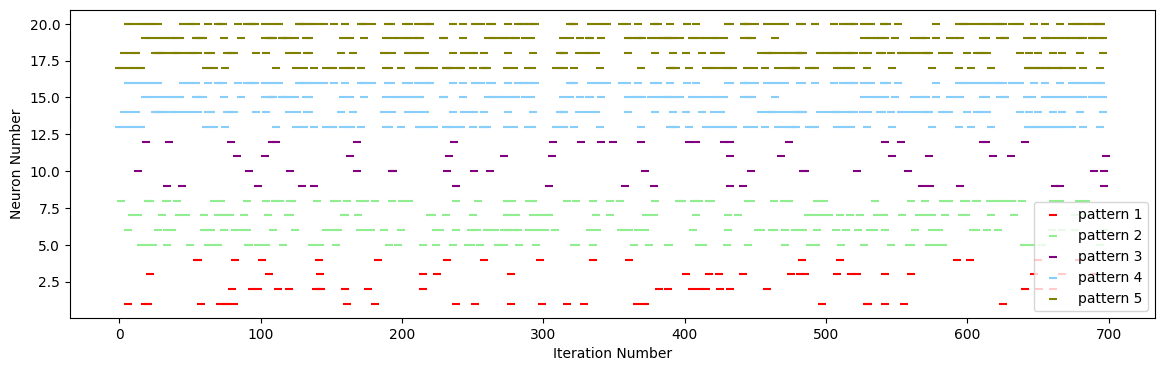

In [6]:
# Convert to numpy array
data_np = np.array([t.numpy() for t in data])

# Initialize lists to hold the positions for the scatter plot
x1, x2, x3, x4, x5 = [], [], [], [], []
y1, y2, y3, y4, y5 = [], [], [], [], []

# Extract positions where elements are one
for i, tensor in enumerate(data_np):
    for j, value in enumerate(tensor):
        if value == 1 and j < 4:
            y1.append(j + 1)
            x1.append(i)
        elif value == 1 and j < 8:
            y2.append(j + 1)
            x2.append(i)
        elif value == 1 and j < 12:
            y3.append(j + 1)
            x3.append(i)
        elif value == 1 and j < 16:
            y4.append(j + 1)
            x4.append(i)
        elif value == 1 and j < 20:
            y5.append(j+1)
            x5.append(i)


# Create the scatter plot
plt.figure(figsize=(14, 4))
plt.scatter(x1, y1, marker='_', color='red', label="pattern 1")
plt.scatter(x2, y2, marker='_', color='lightgreen', label="pattern 2")
plt.scatter(x3, y3, marker='_', color='purple', label="pattern 3")
plt.scatter(x4, y4, marker='_', color='lightskyblue', label="pattern 4")
plt.scatter(x5, y5, marker='_', color='olive', label="pattern 5")

plt.xlabel('Iteration Number', fontsize=10)
plt.ylabel('Neuron Number', fontsize=10)
plt.legend()
plt.show()

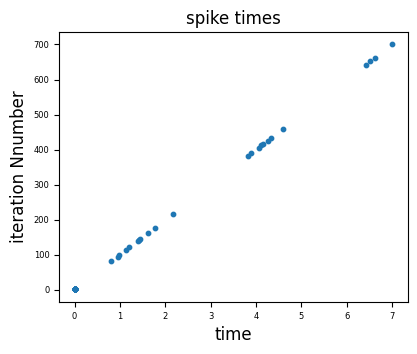

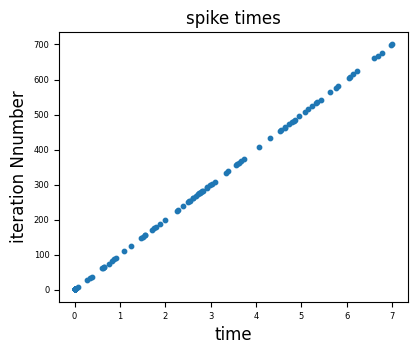

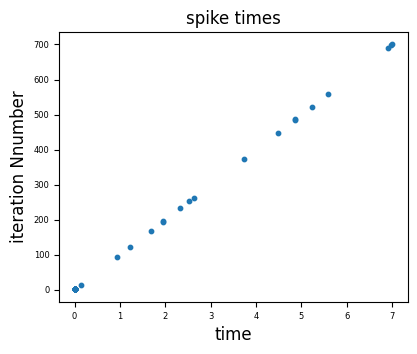

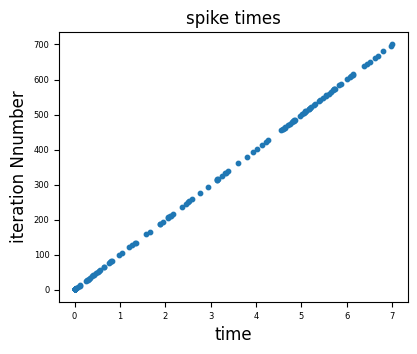

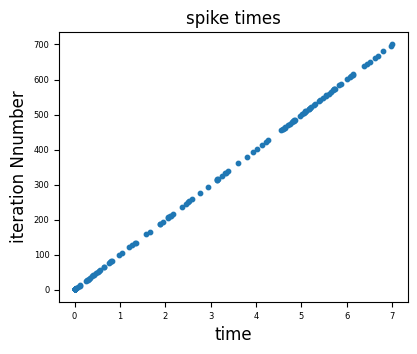

In [7]:
pltHelper.spike_times_plot(ng1)
pltHelper.spike_times_plot(ng2)
pltHelper.spike_times_plot(ng3)
pltHelper.spike_times_plot(ng4)
pltHelper.spike_times_plot(ng5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


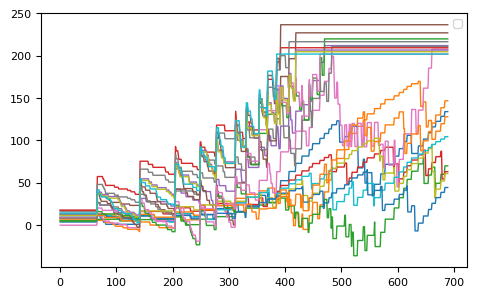

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


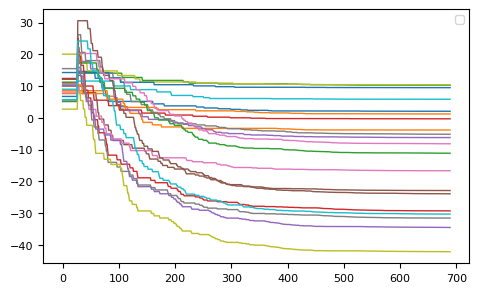

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


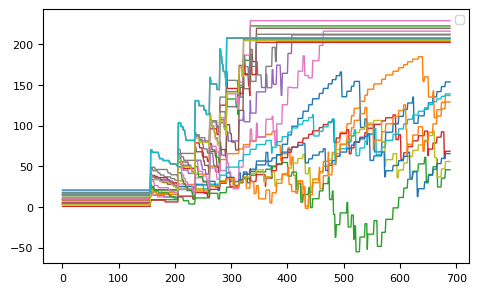

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


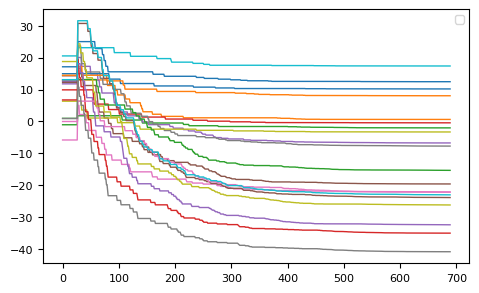

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


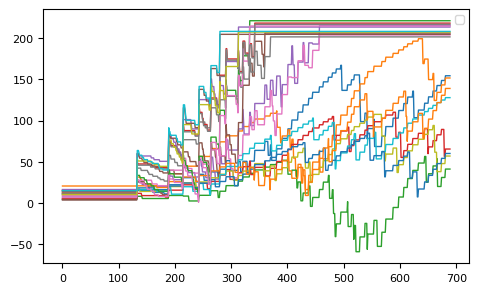

In [8]:

for i in range(5):
    pltHelper.new_plot_weights_changes_of_specific_output__in_stdp(
        s1, s2, s3, s4, s5, i)

In [43]:
def cosine_similarity_plot_v2(synapsGroups: list[SynapseGroup], m: int, n: int, y_lim: list = [-1, 1]) -> None:
    cosine_sims = []
    for i in range(690):
        x1 = torch.Tensor([])
        x2 = torch.Tensor([])
        for s in synapsGroups:
            x1 = torch.cat((x1, torch.Tensor(
                [s['W'][0][:, 0][i, m], s['W'][0][:, 1][i, m], s['W'][0][:, 2][i, m], s['W'][0][:, 3][i, m]])), 0)

            x2 = torch.cat((x2, torch.Tensor(
                [s['W'][0][:, 0][i, n], s['W'][0][:, 1][i, n], s['W'][0][:, 2][i, n], s['W'][0][:, 3][i, n]])), 0)

        cosine_sims.append(
            torch.nn.functional.cosine_similarity(x1, x2, dim=0))

    plt.rcParams.update({'font.size': 6})
    plt.figure(figsize=(4, 3))
    plt.plot(np.arange(690), cosine_sims)
    plt.xlabel('Iteration Nnumber', fontsize=8)
    plt.ylim(y_lim[0], y_lim[1])
    plt.ylabel('Cosine Sim', fontsize=8)
    plt.title('Cosine Similarity Of Weights', fontsize=8)
    plt.show()

1   0


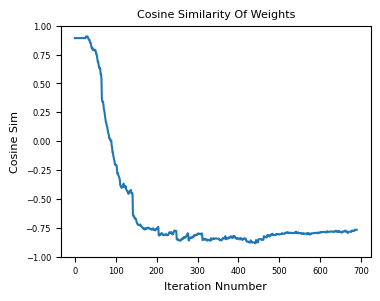

2   0


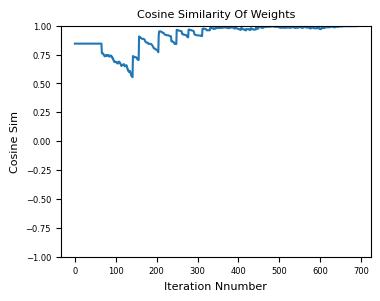

2   1


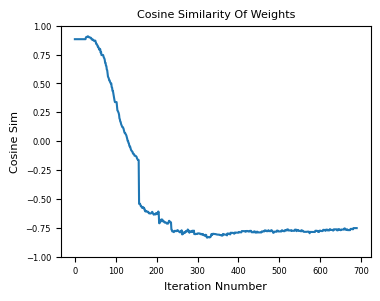

3   0


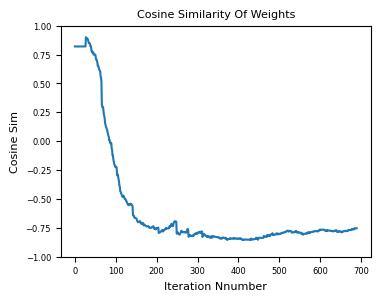

3   1


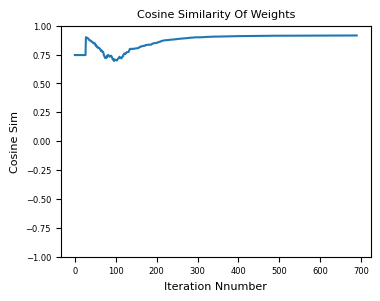

3   2


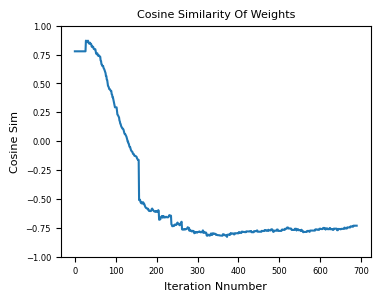

4   0


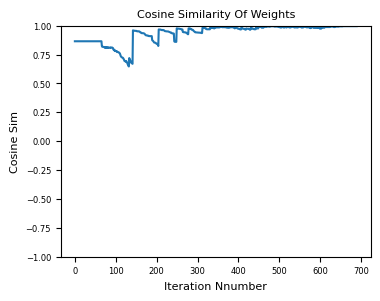

4   1


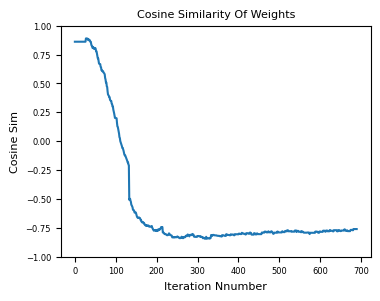

4   2


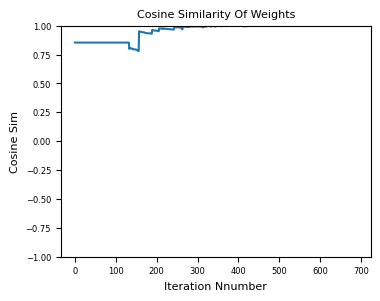

4   3


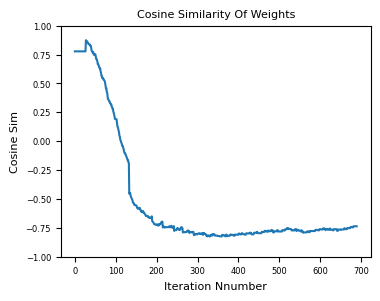

In [44]:
for i in range(5):
    for j in range(i):
        print(i, " ", j)
        cosine_similarity_plot_v2([s1, s2, s3, s4, s5], i, j, [-1, 1])